# Points Per Shot Analysis

This notebook analyzes **Points Per Shot (PPS)** - the average point value generated per shot attempt.

## What is PPS?
- **Formula:** Total Points / Total Shots
- **Range:** 0 (all misses) to 3.0 (100% on 3-pointers)
- **Why it matters:** Combines accuracy and shot value into one efficiency metric

## Analysis
- Calculate team-wide PPS for the season
- Break down PPS by shot zone
- Identify which zones generate the most value per attempt

In [21]:
# Setup - Import libraries and configure
import sys
from pathlib import Path

# Add parent directory to path so we can import bulls
sys.path.insert(0, str(Path().absolute().parent))

from bulls import data, analysis, viz
from bulls.config import CURRENT_SEASON
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Configure matplotlib for better display in notebooks
plt.style.use('default')
%matplotlib inline

print("Bulls Analytics loaded")
print(f"Season: {CURRENT_SEASON}")

Bulls Analytics loaded
Season: 2025-26


## Step 1: Fetch Team Shot Data

In [22]:
# Fetch team shots for the current season
print("Fetching team shot data...")
shots = data.get_team_shots(season=CURRENT_SEASON)

if shots.empty:
    print("No shot data available")
else:
    print(f"Loaded {len(shots):,} shots from {shots['game_id'].nunique()} games")

Fetching team shot data...
Loaded 3,815 shots from 42 games


## Step 2: Season Total PPS

Calculate the team's overall points per shot for the entire season.

In [23]:
# Calculate overall PPS
pps = analysis.points_per_shot(shots)

print(f"=== Bulls Season PPS ===")
print(f"Points Per Shot: {pps['pps']:.3f}")
print(f"Total Points:    {pps['total_points']:,}")
print(f"Total Shots:     {pps['total_shots']:,}")
print(f"FG%:             {pps['fg_pct']:.1f}%")

=== Bulls Season PPS ===
Points Per Shot: 1.104
Total Points:    4,210
Total Shots:     3,814
FG%:             47.4%


## Step 3: PPS by Zone

Break down points per shot by each shot zone to see where the team generates the most value.

In [24]:
# Calculate PPS by zone
pps_zones = analysis.points_per_shot(shots, by_zone=True)

# Convert to DataFrame for better display
zone_data = []
for zone, stats in pps_zones['by_zone'].items():
    zone_data.append({
        'Zone': zone,
        'PPS': stats['pps'],
        'Points': stats['total_points'],
        'Shots': stats['total_shots'],
        'FG%': stats['fg_pct']
    })

zone_df = pd.DataFrame(zone_data).sort_values('PPS', ascending=False)
zone_df = zone_df.reset_index(drop=True)

print("=== PPS by Zone (sorted by efficiency) ===")
print(zone_df.to_string(index=False))

=== PPS by Zone (sorted by efficiency) ===
                 Zone   PPS  Points  Shots  FG%
       Right Corner 3 1.312     282    215 43.7
      Restricted Area 1.268    1720   1356 63.4
        Left Corner 3 1.097     261    238 36.6
    Above the Break 3 1.033    1233   1194 34.4
In The Paint (Non-RA) 0.906     578    638 45.3
            Mid-Range 0.786     136    173 39.3


## Step 4: Visualize Zone Efficiency

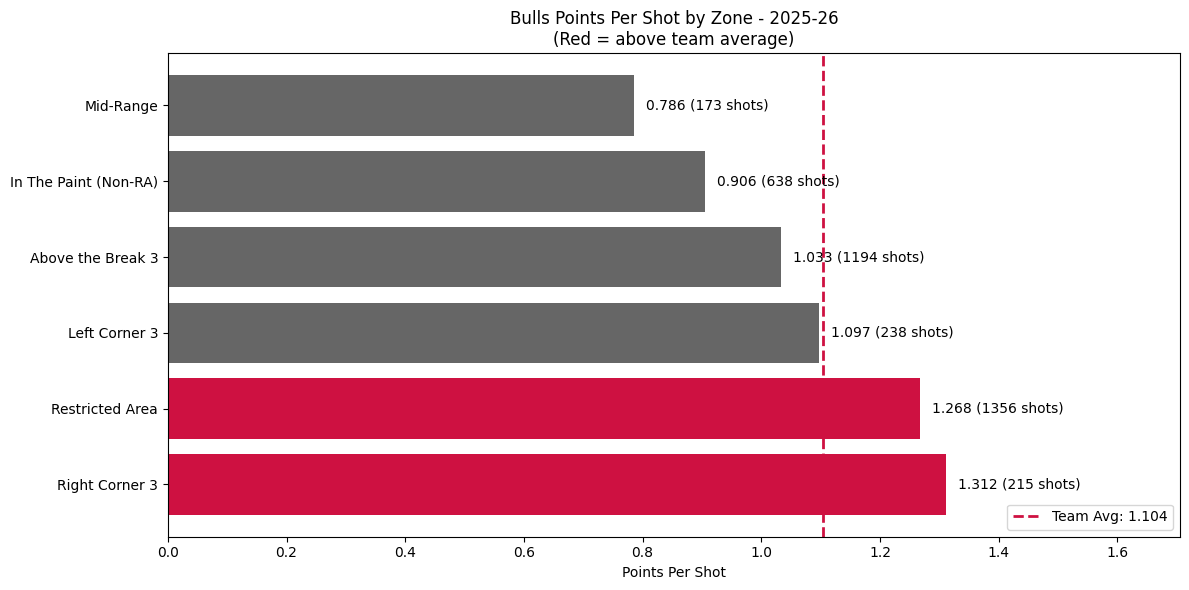

In [25]:
# Create bar chart of PPS by zone
fig, ax = plt.subplots(figsize=(12, 6))

# Sort by PPS for visualization
colors = ['#CE1141' if pps > pps_zones['overall']['pps'] else '#666666' 
          for pps in zone_df['PPS']]

bars = ax.barh(zone_df['Zone'], zone_df['PPS'], color=colors)

# Add team average line
ax.axvline(x=pps_zones['overall']['pps'], color='#CE1141', linestyle='--', 
           linewidth=2, label=f"Team Avg: {pps_zones['overall']['pps']:.3f}")

# Add value labels
for bar, row in zip(bars, zone_df.itertuples()):
    ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
            f"{row.PPS:.3f} ({row.Shots} shots)",
            va='center', fontsize=10)

ax.set_xlabel('Points Per Shot')
ax.set_title(f'Bulls Points Per Shot by Zone - {CURRENT_SEASON}\n(Red = above team average)')
ax.legend(loc='lower right')
ax.set_xlim(0, max(zone_df['PPS']) * 1.3)

plt.tight_layout()
plt.show()

## Step 5: Zone Volume vs Efficiency

Compare shot volume (how often we shoot from each zone) against efficiency (PPS).

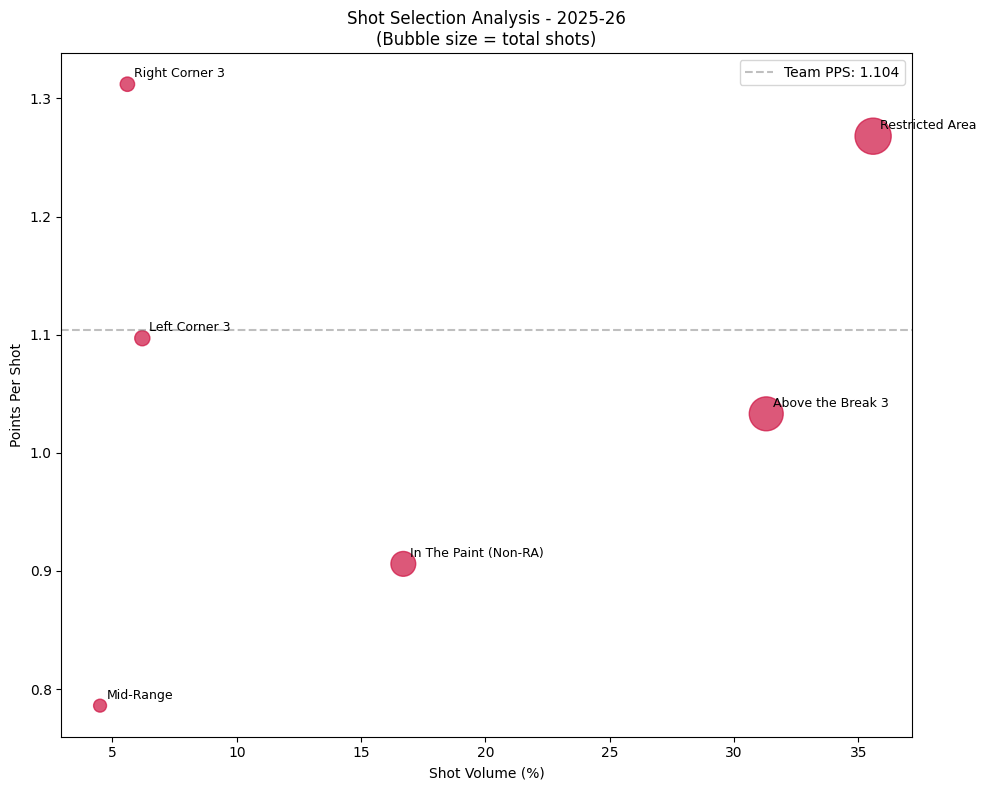

In [26]:
# Scatter plot: Volume vs Efficiency
fig, ax = plt.subplots(figsize=(10, 8))

# Calculate shot percentage for each zone
zone_df['Shot%'] = (zone_df['Shots'] / zone_df['Shots'].sum() * 100).round(1)

scatter = ax.scatter(zone_df['Shot%'], zone_df['PPS'], 
                     s=zone_df['Shots']/2, c='#CE1141', alpha=0.7)

# Add zone labels
for _, row in zone_df.iterrows():
    ax.annotate(row['Zone'], (row['Shot%'], row['PPS']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

# Add reference lines
ax.axhline(y=pps_zones['overall']['pps'], color='gray', linestyle='--', 
           alpha=0.5, label=f"Team PPS: {pps_zones['overall']['pps']:.3f}")

ax.set_xlabel('Shot Volume (%)')
ax.set_ylabel('Points Per Shot')
ax.set_title(f'Shot Selection Analysis - {CURRENT_SEASON}\n(Bubble size = total shots)')
ax.legend()

plt.tight_layout()
plt.show()

## Step 6: PPS vs FG% by Zone

Compare Points Per Shot (PPS) against Field Goal Percentage (FG%) to identify which zones provide the best balance of efficiency and accuracy. Zones in the upper-right quadrant represent high-value shot locations (both accurate and efficient).

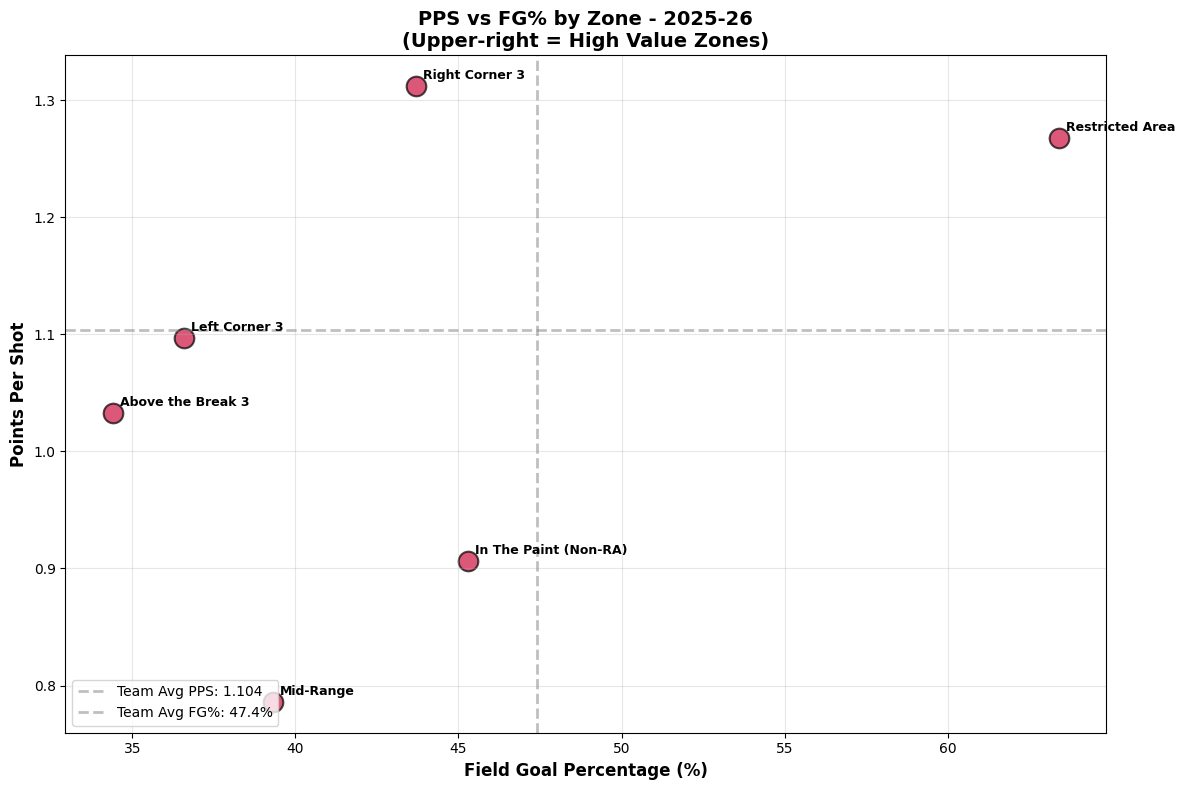

In [27]:
# Scatter plot: PPS vs FG% by Zone
fig, ax = plt.subplots(figsize=(12, 8))

# Extract PPS and FG% for each zone
fg_pct_values = []
pps_values = []
zone_names = []

for zone, stats in pps_zones['by_zone'].items():
    zone_names.append(zone)
    fg_pct_values.append(stats['fg_pct'])
    pps_values.append(stats['pps'])

# Create scatter plot
scatter = ax.scatter(fg_pct_values, pps_values, 
                     s=200, c='#CE1141', alpha=0.7, edgecolors='black', linewidth=1.5)

# Add zone labels
for i, zone in enumerate(zone_names):
    ax.annotate(zone, (fg_pct_values[i], pps_values[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=9, fontweight='bold')

# Add reference lines for team averages
team_avg_fg = pps_zones['overall']['fg_pct']
team_avg_pps = pps_zones['overall']['pps']

ax.axhline(y=team_avg_pps, color='gray', linestyle='--', 
           alpha=0.5, linewidth=2, label=f"Team Avg PPS: {team_avg_pps:.3f}")
ax.axvline(x=team_avg_fg, color='gray', linestyle='--', 
           alpha=0.5, linewidth=2, label=f"Team Avg FG%: {team_avg_fg:.1f}%")

ax.set_xlabel('Field Goal Percentage (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Points Per Shot', fontsize=12, fontweight='bold')
ax.set_title(f'PPS vs FG% by Zone - {CURRENT_SEASON}\n(Upper-right = High Value Zones)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='lower left')

plt.tight_layout()
plt.show()

## Bulls Summary So Far

**Key Insights:**
- **PPS** tells you how many points to expect per shot attempt from each zone
- Zones above the team average (in red) are where the Bulls generate the most efficient offense
- The scatter plot shows if shot selection aligns with efficiency (ideally, high-volume zones should have high PPS)

---

# Part 2: League-Wide PPS Analysis

Now let's compare the Bulls to the entire league. We'll fetch shot data for all 30 NBA teams and analyze where the Bulls rank.

## Step 7: Fetch League-Wide Shot Data

**⚠️ Note:** This cell fetches shot data for all 30 NBA teams. Due to API rate limits, this takes approximately **9 minutes** to complete. You'll see progress updates as each team loads.

In [28]:
# Fetch league-wide shot data for current season
import time as _time
start_time = _time.time()

print(f"Fetching shot data for all 30 NBA teams ({CURRENT_SEASON})...")
print("=" * 60)

league_shots = data.get_league_shots(season=CURRENT_SEASON)

elapsed = _time.time() - start_time
print(f"\n✓ Complete! Fetched {len(league_shots):,} total shots in {elapsed/60:.1f} minutes")
print(f"  Teams: {league_shots['team_abbr'].nunique()}")

Fetching shot data for all 30 NBA teams (2025-26)...
[1/30] Fetching Atlanta Hawks...
    -> 4,107 shots
[2/30] Fetching Boston Celtics...
    -> 3,817 shots
[3/30] Fetching Brooklyn Nets...
    -> 3,498 shots
[4/30] Fetching Charlotte Hornets...
    -> 3,839 shots
[5/30] Fetching Chicago Bulls...
    -> 3,815 shots
[6/30] Fetching Cleveland Cavaliers...
    -> 4,051 shots
[7/30] Fetching Dallas Mavericks...
    -> 3,927 shots
[8/30] Fetching Denver Nuggets...
    -> 3,749 shots
[9/30] Fetching Detroit Pistons...
    -> 3,679 shots
[10/30] Fetching Golden State Warriors...
    -> 3,909 shots
[11/30] Fetching Houston Rockets...
    -> 3,631 shots
[12/30] Fetching Indiana Pacers...
    -> 3,930 shots
[13/30] Fetching LA Clippers...
    -> 3,474 shots
[14/30] Fetching Los Angeles Lakers...
    -> 3,434 shots
[15/30] Fetching Memphis Grizzlies...
    -> 3,734 shots
[16/30] Fetching Miami Heat...
    -> 4,019 shots
[17/30] Fetching Milwaukee Bucks...
    -> 3,583 shots
[18/30] Fetching Minn

## Step 8: League-Wide PPS Statistics

Calculate league-wide PPS metrics and zone efficiency rankings.

In [29]:
# Calculate league-wide PPS statistics
league_pps = analysis.league_pps_by_zone(league_shots)

# Display overall league stats
print("=== League-Wide PPS Statistics ===")
print(f"Overall PPS:    {league_pps['league_overall']['pps']:.3f}")
print(f"Total Points:   {league_pps['league_overall']['total_points']:,}")
print(f"Total Shots:    {league_pps['league_overall']['total_shots']:,}")
print(f"League FG%:     {league_pps['league_overall']['fg_pct']:.1f}%")
print(f"\nTeams analyzed: {len(league_pps['by_team'])}")

# Zone value rankings (Backcourt already excluded by default)
print("\n=== Zone Efficiency Rankings (League-Wide) ===")
zone_rankings = analysis.zone_value_ranking(league_pps)
print(zone_rankings.to_string(index=False))

=== League-Wide PPS Statistics ===
Overall PPS:    1.088
Total Points:   124,557
Total Shots:    114,510
League FG%:     46.9%

Teams analyzed: 30

=== Zone Efficiency Rankings (League-Wide) ===
                 Zone   PPS  FG%  Points  Shots  Volume%  Rank
      Restricted Area 1.335 66.7   43066  32268     28.2     1
       Right Corner 3 1.150 38.3    6813   5925      5.2     2
        Left Corner 3 1.142 38.1    7203   6305      5.5     3
    Above the Break 3 1.053 35.1   37091  35228     30.8     4
In The Paint (Non-RA) 0.894 44.7   20752  23225     20.3     5
            Mid-Range 0.833 41.7    9632  11559     10.1     6


## Step 9: League Zone Efficiency Visualization

Visualize how efficient each shot zone is across the entire league.

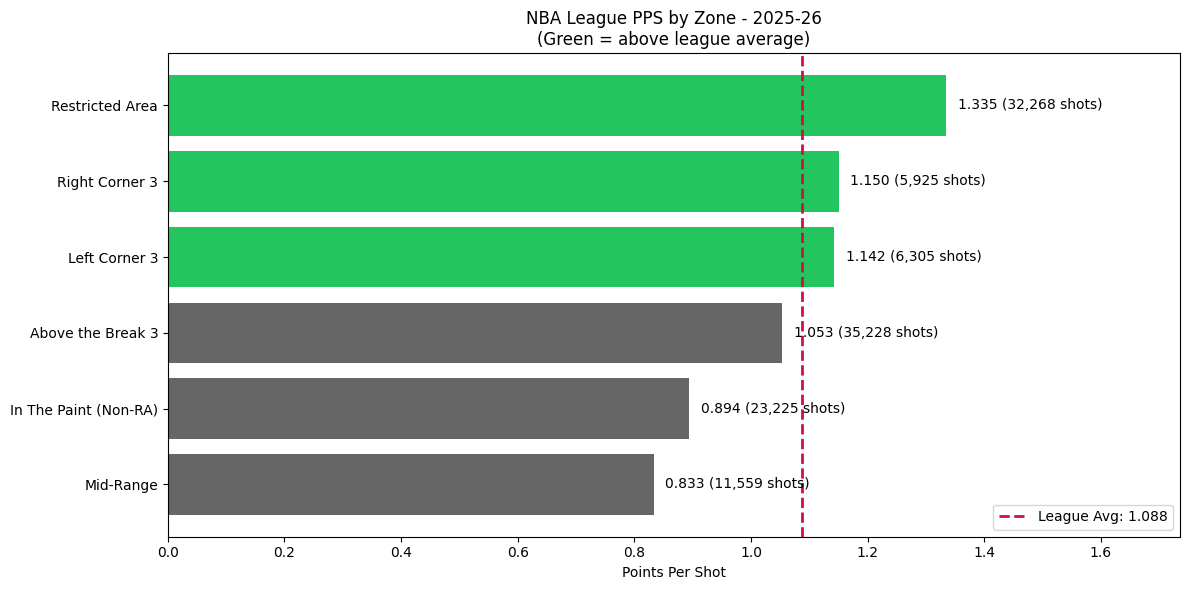

In [30]:
# Horizontal bar chart of league PPS by zone
fig, ax = plt.subplots(figsize=(12, 6))

# Sort by PPS
zone_plot = zone_rankings.sort_values('PPS', ascending=True)
league_avg_pps = league_pps['league_overall']['pps']

# Color bars based on above/below league average
colors = ['#22c55e' if pps > league_avg_pps else '#666666' for pps in zone_plot['PPS']]

bars = ax.barh(zone_plot['Zone'], zone_plot['PPS'], color=colors)

# Add league average line
ax.axvline(x=league_avg_pps, color='#CE1141', linestyle='--', 
           linewidth=2, label=f"League Avg: {league_avg_pps:.3f}")

# Add value labels
for bar, row in zip(bars, zone_plot.itertuples()):
    ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
            f"{row.PPS:.3f} ({row.Shots:,} shots)",
            va='center', fontsize=10)

ax.set_xlabel('Points Per Shot')
ax.set_title(f'NBA League PPS by Zone - {CURRENT_SEASON}\n(Green = above league average)')
ax.legend(loc='lower right')
ax.set_xlim(0, max(zone_plot['PPS']) * 1.3)

plt.tight_layout()
plt.show()

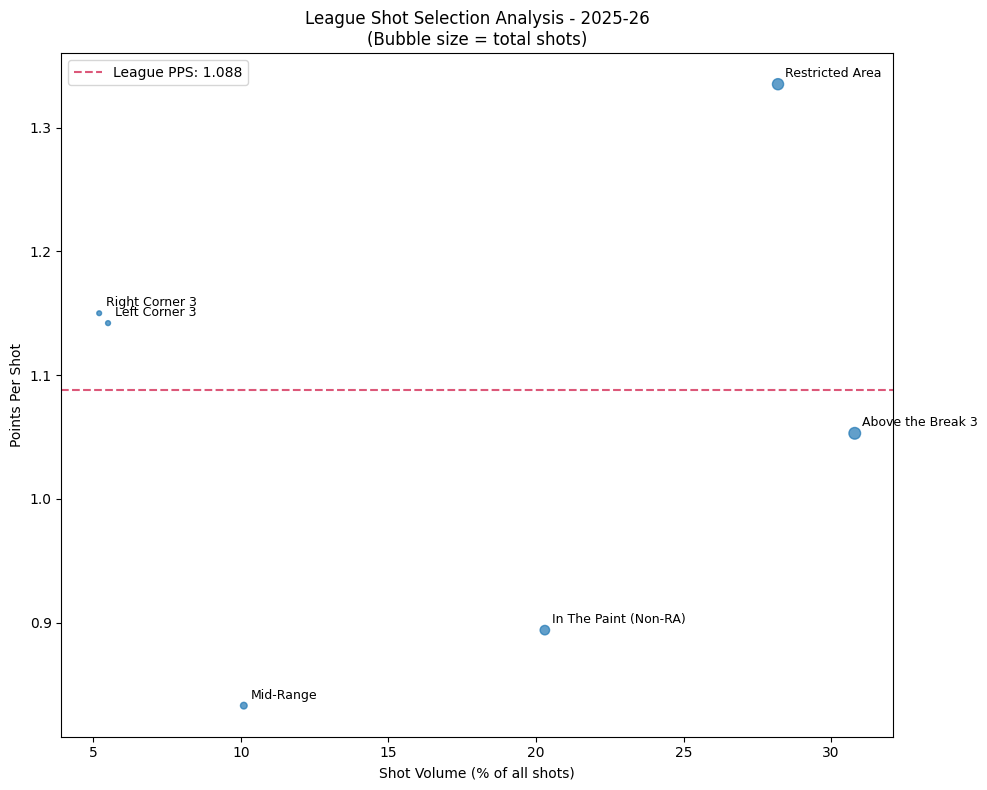

In [31]:
# Bubble chart: Shot Volume vs PPS (League-wide)
fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(zone_rankings['Volume%'], zone_rankings['PPS'], 
                     s=zone_rankings['Shots']/500, c='#1f77b4', alpha=0.7)

# Add zone labels
for _, row in zone_rankings.iterrows():
    ax.annotate(row['Zone'], (row['Volume%'], row['PPS']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

# Add reference lines
ax.axhline(y=league_avg_pps, color='#CE1141', linestyle='--', 
           alpha=0.7, label=f"League PPS: {league_avg_pps:.3f}")

ax.set_xlabel('Shot Volume (% of all shots)')
ax.set_ylabel('Points Per Shot')
ax.set_title(f'League Shot Selection Analysis - {CURRENT_SEASON}\n(Bubble size = total shots)')
ax.legend()

plt.tight_layout()
plt.show()

## Step 10: All 30 Teams PPS Rankings

See where the Bulls rank among all NBA teams in overall points per shot efficiency.

In [32]:
# Create team PPS rankings DataFrame
team_comparison = analysis.team_zone_comparison(league_pps)

# Add rank column
team_comparison['Rank'] = range(1, len(team_comparison) + 1)

# Find Bulls rank
bulls_rank = team_comparison[team_comparison['Team'] == 'CHI']['Rank'].values[0]
bulls_pps = team_comparison[team_comparison['Team'] == 'CHI']['Overall'].values[0]

print(f"=== All 30 Teams PPS Rankings ===")
print(f"Bulls Rank: #{bulls_rank} of 30 teams")
print(f"Bulls PPS:  {bulls_pps:.3f}")
print(f"League Avg: {league_avg_pps:.3f}")
print(f"Difference: {bulls_pps - league_avg_pps:+.3f}")
print()

# Display top 10 and Bulls position
print("Top 10 Teams:")
print(team_comparison[['Rank', 'Team', 'Overall']].head(10).to_string(index=False))

if bulls_rank > 10:
    print(f"\n... Bulls at #{bulls_rank} ...")
    bulls_row = team_comparison[team_comparison['Team'] == 'CHI'][['Rank', 'Team', 'Overall']]
    print(bulls_row.to_string(index=False))

=== All 30 Teams PPS Rankings ===
Bulls Rank: #10 of 30 teams
Bulls PPS:  1.104
League Avg: 1.088
Difference: +0.016

Top 10 Teams:
 Rank Team  Overall
    1  DEN    1.160
    2  MIL    1.138
    3  LAL    1.135
    4  OKC    1.133
    5  MIN    1.130
    6  BOS    1.116
    7  GSW    1.108
    8  LAC    1.107
    9  ATL    1.105
   10  CHI    1.104


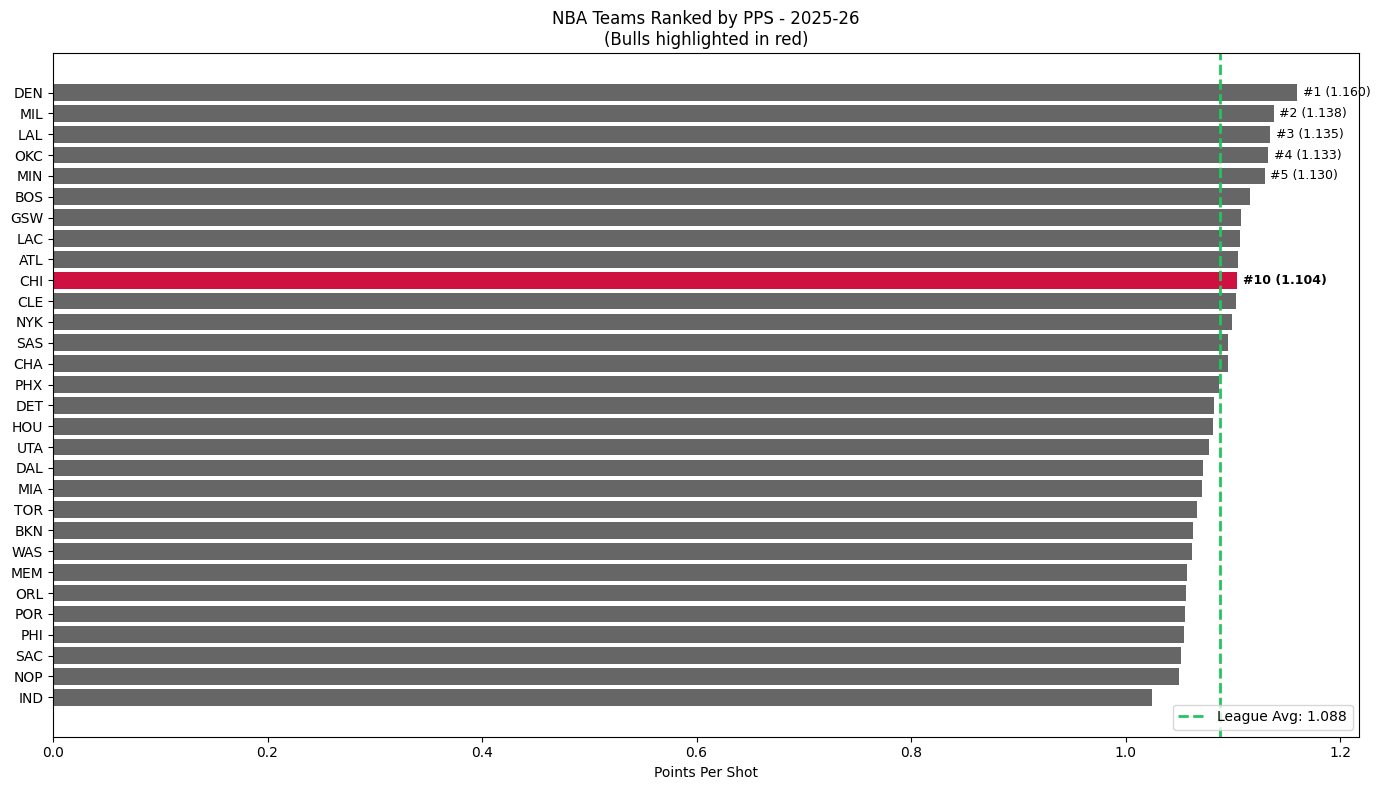

In [33]:
# Bar chart of all 30 teams sorted by PPS (Bulls highlighted in red)
fig, ax = plt.subplots(figsize=(14, 8))

# Sort by PPS descending
teams_sorted = team_comparison.sort_values('Overall', ascending=True)

# Color Bulls red, others gray
colors = ['#CE1141' if team == 'CHI' else '#666666' for team in teams_sorted['Team']]

bars = ax.barh(teams_sorted['Team'], teams_sorted['Overall'], color=colors)

# Add league average line
ax.axvline(x=league_avg_pps, color='#22c55e', linestyle='--', 
           linewidth=2, label=f"League Avg: {league_avg_pps:.3f}")

# Add value labels for top 5 and Bulls
for i, (bar, team, pps) in enumerate(zip(bars, teams_sorted['Team'], teams_sorted['Overall'])):
    rank = len(teams_sorted) - i
    if rank <= 5 or team == 'CHI':
        ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
                f"#{rank} ({pps:.3f})",
                va='center', fontsize=9, fontweight='bold' if team == 'CHI' else 'normal')

ax.set_xlabel('Points Per Shot')
ax.set_title(f'NBA Teams Ranked by PPS - {CURRENT_SEASON}\n(Bulls highlighted in red)')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

## Step 11: Bulls vs League Comparison

Compare Bulls PPS to league average in each zone to identify strengths and areas for improvement.

In [34]:
# Build comparison DataFrame: Bulls PPS vs League PPS per zone
bulls_zones = league_pps['by_team']['CHI']['by_zone']
league_zones = league_pps['by_zone']

comparison_data = []
for zone in league_zones:
    league_zone_pps = league_zones[zone]['pps']
    bulls_zone_pps = bulls_zones.get(zone, {}).get('pps', 0)
    bulls_zone_shots = bulls_zones.get(zone, {}).get('total_shots', 0)
    
    diff = bulls_zone_pps - league_zone_pps
    
    comparison_data.append({
        'Zone': zone,
        'Bulls PPS': bulls_zone_pps,
        'League PPS': league_zone_pps,
        'Difference': diff,
        'Bulls Shots': bulls_zone_shots,
        'Status': '✓ Above' if diff > 0 else '✗ Below'
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('Difference', ascending=False)

print("=== Bulls vs League PPS by Zone ===")
print(comparison_df.to_string(index=False))

# Summary
above_avg = len(comparison_df[comparison_df['Difference'] > 0])
below_avg = len(comparison_df[comparison_df['Difference'] < 0])
print(f"\n✓ Bulls above league avg in {above_avg} zones")
print(f"✗ Bulls below league avg in {below_avg} zones")

=== Bulls vs League PPS by Zone ===
                 Zone  Bulls PPS  League PPS  Difference  Bulls Shots  Status
       Right Corner 3      1.312       1.150       0.162          215 ✓ Above
In The Paint (Non-RA)      0.906       0.894       0.012          638 ✓ Above
    Above the Break 3      1.033       1.053      -0.020         1194 ✗ Below
        Left Corner 3      1.097       1.142      -0.045          238 ✗ Below
            Mid-Range      0.786       0.833      -0.047          173 ✗ Below
      Restricted Area      1.268       1.335      -0.067         1356 ✗ Below

✓ Bulls above league avg in 2 zones
✗ Bulls below league avg in 4 zones


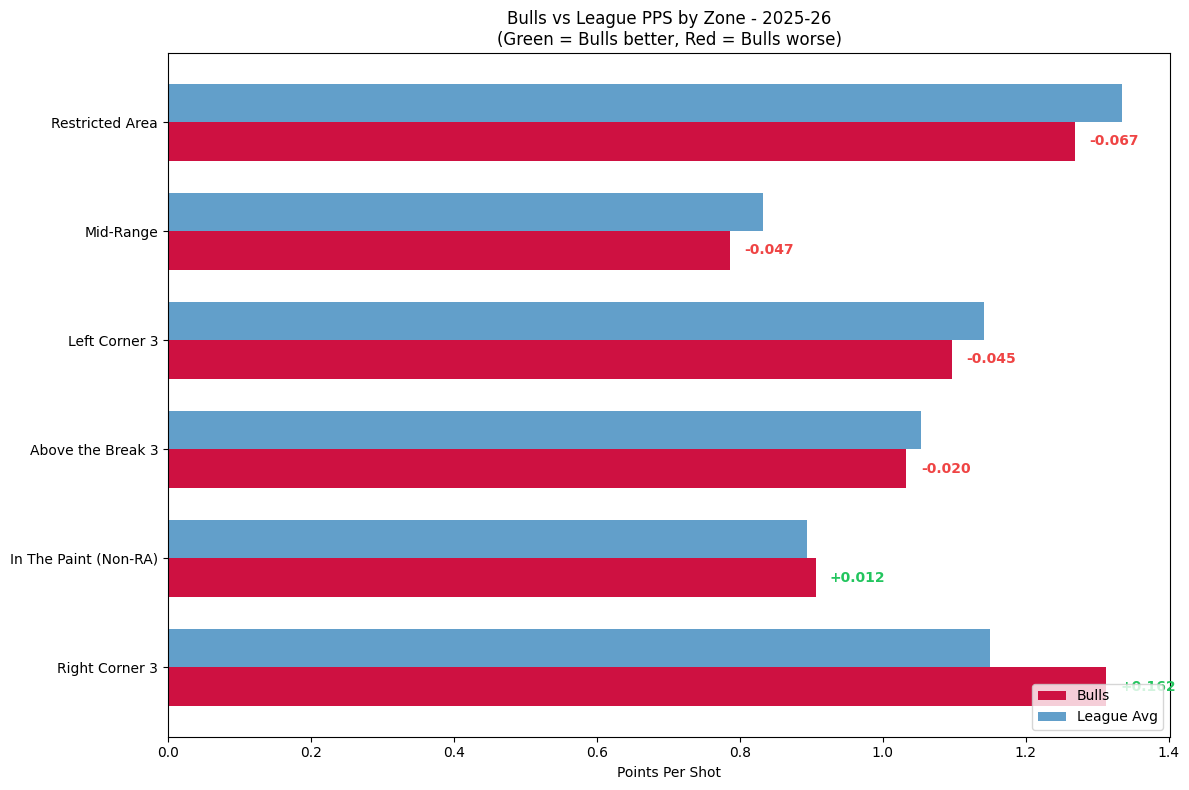

In [35]:
# Grouped horizontal bar chart: Bulls vs League PPS with difference annotations
fig, ax = plt.subplots(figsize=(12, 8))

zones = comparison_df['Zone'].values
y_pos = np.arange(len(zones))
bar_height = 0.35

# Create grouped bars
bars_bulls = ax.barh(y_pos - bar_height/2, comparison_df['Bulls PPS'], bar_height, 
                     label='Bulls', color='#CE1141')
bars_league = ax.barh(y_pos + bar_height/2, comparison_df['League PPS'], bar_height,
                      label='League Avg', color='#1f77b4', alpha=0.7)

# Add difference annotations
for i, (zone_diff, bulls_pps) in enumerate(zip(comparison_df['Difference'], comparison_df['Bulls PPS'])):
    color = '#22c55e' if zone_diff > 0 else '#ef4444'
    sign = '+' if zone_diff > 0 else ''
    ax.text(bulls_pps + 0.02, i - bar_height/2, f'{sign}{zone_diff:.3f}',
            va='center', fontsize=10, fontweight='bold', color=color)

ax.set_yticks(y_pos)
ax.set_yticklabels(zones)
ax.set_xlabel('Points Per Shot')
ax.set_title(f'Bulls vs League PPS by Zone - {CURRENT_SEASON}\n(Green = Bulls better, Red = Bulls worse)')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

## Step 12: Team Efficiency Heatmap

Visualize all 30 teams' PPS across all zones in a single heatmap. This reveals which teams dominate specific zones.

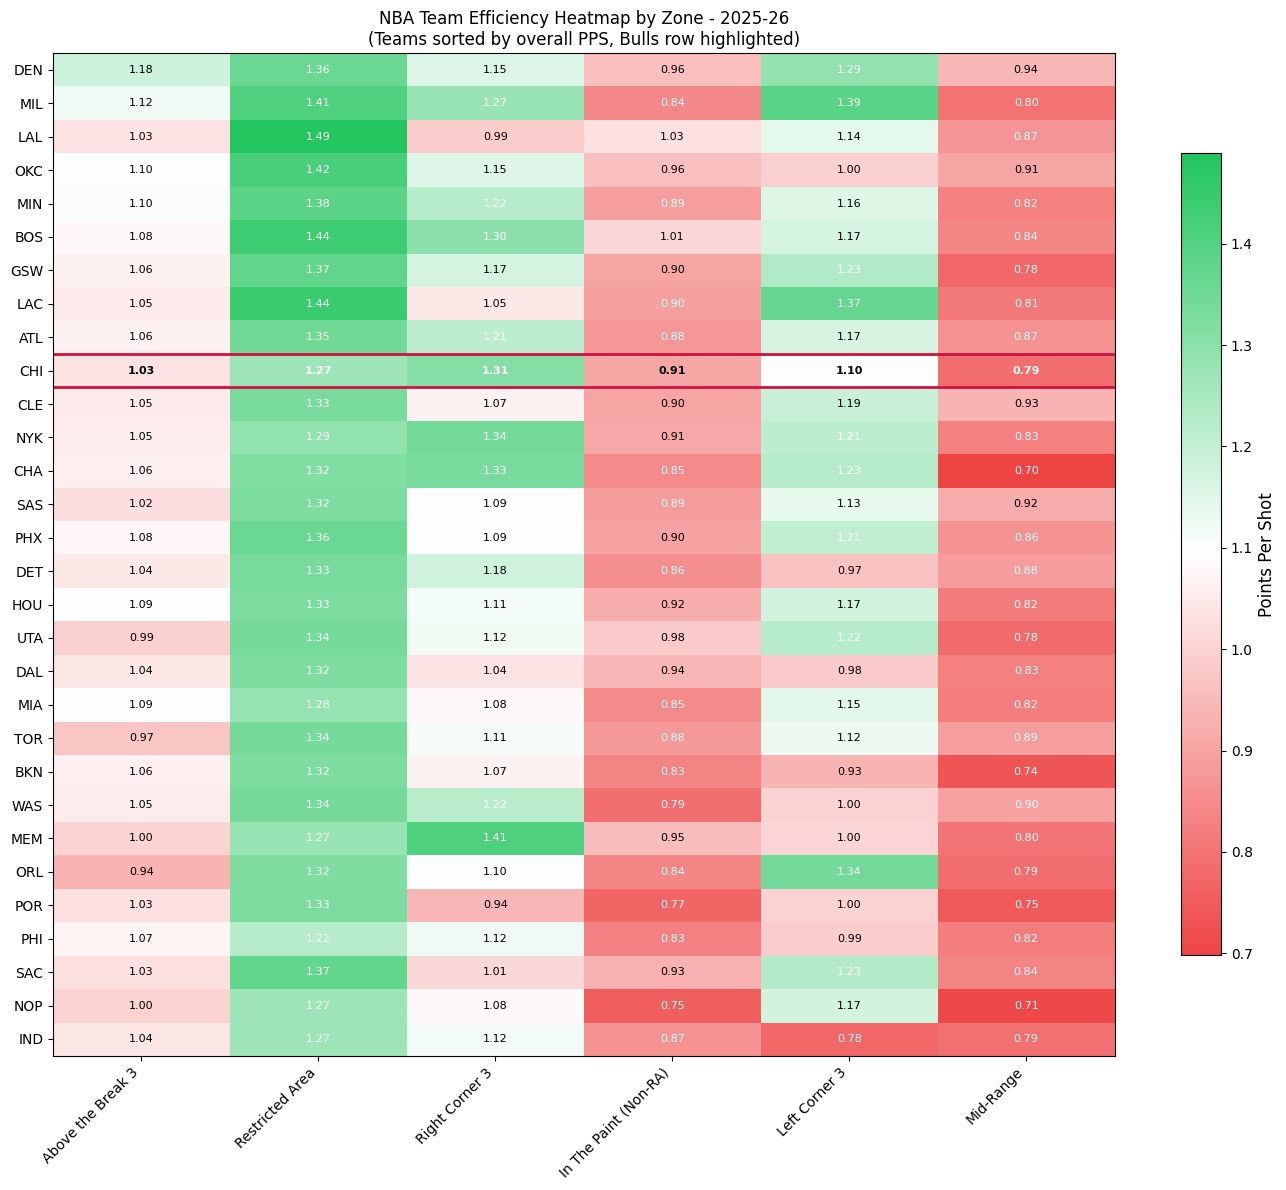

In [36]:
# Create heatmap data: 30 teams x 6 zones
from matplotlib.colors import LinearSegmentedColormap

# Get zones (Backcourt already excluded by default)
zones = list(league_pps['by_zone'].keys())

# Build matrix
heatmap_data = []
teams_list = []

for team_abbr, team_data in sorted(league_pps['by_team'].items(), 
                                    key=lambda x: x[1]['overall']['pps'], reverse=True):
    teams_list.append(team_abbr)
    row = []
    for zone in zones:
        pps = team_data['by_zone'].get(zone, {}).get('pps', 0)
        row.append(pps)
    heatmap_data.append(row)

heatmap_df = pd.DataFrame(heatmap_data, index=teams_list, columns=zones)

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 12))

# Custom colormap: red -> white -> green
cmap = LinearSegmentedColormap.from_list('efficiency', ['#ef4444', '#ffffff', '#22c55e'])

im = ax.imshow(heatmap_df.values, cmap=cmap, aspect='auto')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Points Per Shot', fontsize=12)

# Set ticks
ax.set_xticks(np.arange(len(zones)))
ax.set_yticks(np.arange(len(teams_list)))
ax.set_xticklabels(zones, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(teams_list, fontsize=10)

# Highlight Bulls row
bulls_idx = teams_list.index('CHI')
ax.axhline(y=bulls_idx - 0.5, color='#CE1141', linewidth=2)
ax.axhline(y=bulls_idx + 0.5, color='#CE1141', linewidth=2)

# Add values to cells
for i in range(len(teams_list)):
    for j in range(len(zones)):
        val = heatmap_df.iloc[i, j]
        text_color = 'white' if val < 0.9 or val > 1.2 else 'black'
        fontweight = 'bold' if teams_list[i] == 'CHI' else 'normal'
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', 
                fontsize=8, color=text_color, fontweight=fontweight)

ax.set_title(f'NBA Team Efficiency Heatmap by Zone - {CURRENT_SEASON}\n(Teams sorted by overall PPS, Bulls row highlighted)')

plt.tight_layout()
plt.show()

## Step 13: Bulls Percentile Rankings by Zone

For each zone, calculate where the Bulls rank percentile-wise among all 30 teams. This quickly identifies relative strengths (high percentile) vs weaknesses (low percentile).

In [37]:
# Calculate Bulls percentile rank in each zone
# Using numpy instead of scipy for percentile calculation

def percentileofscore(values, score):
    """Calculate the percentile rank of a score relative to a list of values."""
    values = np.array(values)
    return (np.sum(values <= score) / len(values)) * 100

percentile_data = []
zones_for_radar = []

for zone in zones:
    # Get all teams' PPS for this zone
    zone_pps_values = []
    bulls_zone_pps = None
    
    for team_abbr, team_data in league_pps['by_team'].items():
        pps = team_data['by_zone'].get(zone, {}).get('pps', None)
        if pps is not None:
            zone_pps_values.append(pps)
            if team_abbr == 'CHI':
                bulls_zone_pps = pps
    
    if bulls_zone_pps is not None and len(zone_pps_values) > 0:
        # Calculate percentile (0-100)
        percentile = percentileofscore(zone_pps_values, bulls_zone_pps)
        rank = sum(1 for p in zone_pps_values if p > bulls_zone_pps) + 1
        
        percentile_data.append({
            'Zone': zone,
            'Bulls PPS': bulls_zone_pps,
            'Percentile': percentile,
            'Rank': rank,
            'Teams': len(zone_pps_values)
        })
        zones_for_radar.append(zone)

percentile_df = pd.DataFrame(percentile_data).sort_values('Percentile', ascending=False)

print("=== Bulls Percentile Rankings by Zone ===")
print("(100th percentile = best in league, 0 = worst)")
print()
print(percentile_df.to_string(index=False))

=== Bulls Percentile Rankings by Zone ===
(100th percentile = best in league, 0 = worst)

                 Zone  Bulls PPS  Percentile  Rank  Teams
       Right Corner 3      1.312   90.000000     4     30
In The Paint (Non-RA)      0.906   66.666667    11     30
        Left Corner 3      1.097   33.333333    21     30
    Above the Break 3      1.033   30.000000    22     30
            Mid-Range      0.786   26.666667    23     30
      Restricted Area      1.268   10.000000    28     30


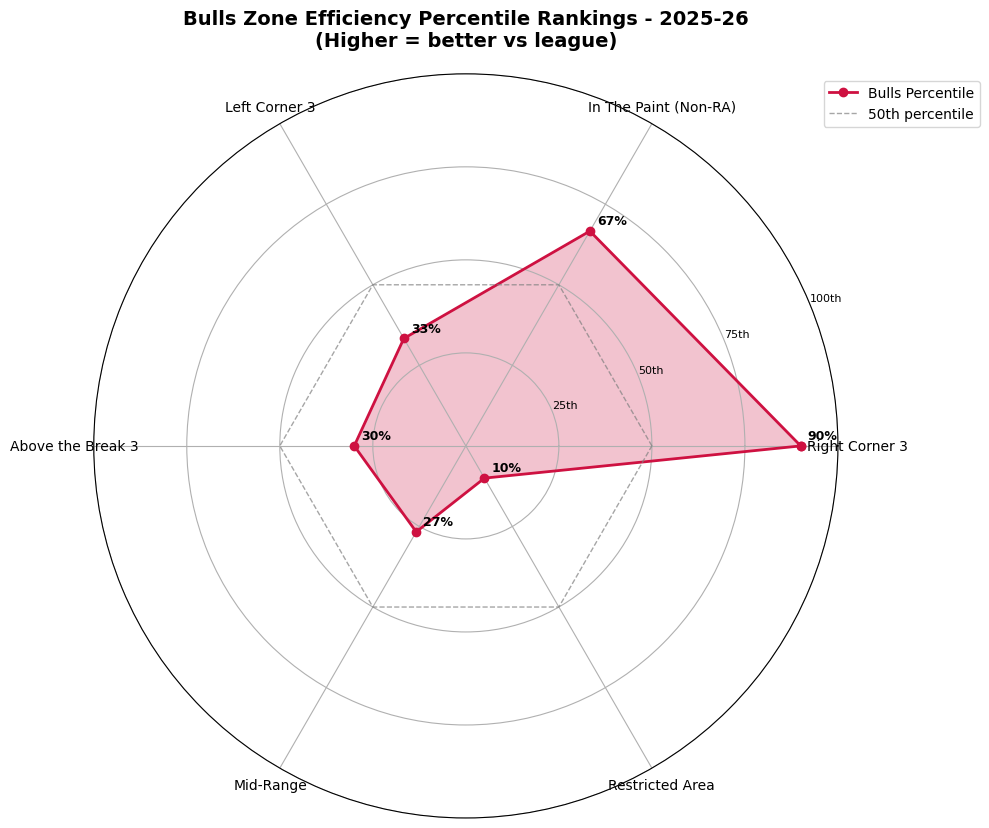

In [38]:
# Radar chart of Bulls percentile rankings
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Get data in order
radar_zones = percentile_df['Zone'].tolist()
percentiles = percentile_df['Percentile'].tolist()

# Number of zones
N = len(radar_zones)

# Calculate angles for each zone
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the polygon

# Add first value to end to close the radar
percentiles += percentiles[:1]

# Plot
ax.plot(angles, percentiles, 'o-', linewidth=2, color='#CE1141', label='Bulls Percentile')
ax.fill(angles, percentiles, alpha=0.25, color='#CE1141')

# Add 50th percentile reference line
ax.plot(angles, [50] * len(angles), '--', linewidth=1, color='gray', alpha=0.7, label='50th percentile')

# Set labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(radar_zones, fontsize=10)
ax.set_ylim(0, 100)
ax.set_yticks([25, 50, 75, 100])
ax.set_yticklabels(['25th', '50th', '75th', '100th'], fontsize=8)

# Add value labels at each point
for angle, pct, zone in zip(angles[:-1], percentiles[:-1], radar_zones):
    ax.annotate(f'{pct:.0f}%', 
                xy=(angle, pct), 
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=9, fontweight='bold')

ax.set_title(f'Bulls Zone Efficiency Percentile Rankings - {CURRENT_SEASON}\n(Higher = better vs league)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

plt.tight_layout()
plt.show()

## Step 14: "What-If" Optimal Shot Selection Analysis

What would the Bulls' PPS be if they matched the league's best shot distribution? This quantifies whether the Bulls are leaving points on the table due to shot selection.

In [39]:
# What-If Analysis: Optimal Shot Selection
# Find the top PPS team and their shot distribution
top_team = team_comparison.iloc[0]['Team']
top_team_zones = league_pps['by_team'][top_team]['by_zone']
top_team_total_shots = sum(z.get('total_shots', 0) for z in top_team_zones.values())

# Calculate optimal shot distribution from top 5 teams
top_5_teams = team_comparison.head(5)['Team'].tolist()

# Get average shot distribution from top 5 teams
optimal_distribution = {}
for zone in zones:
    zone_pcts = []
    for team in top_5_teams:
        team_zones = league_pps['by_team'][team]['by_zone']
        team_total = sum(z.get('total_shots', 0) for z in team_zones.values())
        if team_total > 0 and zone in team_zones:
            zone_pcts.append(team_zones[zone]['total_shots'] / team_total * 100)
    if zone_pcts:
        optimal_distribution[zone] = np.mean(zone_pcts)

# Bulls current distribution
bulls_total_shots = sum(bulls_zones.get(z, {}).get('total_shots', 0) for z in zones)
bulls_distribution = {}
for zone in zones:
    if zone in bulls_zones:
        bulls_distribution[zone] = bulls_zones[zone]['total_shots'] / bulls_total_shots * 100
    else:
        bulls_distribution[zone] = 0

# Calculate hypothetical PPS if Bulls used optimal distribution with their current efficiency
hypothetical_points = 0
for zone in zones:
    bulls_zone_pps = bulls_zones.get(zone, {}).get('pps', 0)
    optimal_pct = optimal_distribution.get(zone, 0) / 100
    hypothetical_shots = bulls_total_shots * optimal_pct
    hypothetical_points += hypothetical_shots * bulls_zone_pps

hypothetical_pps = hypothetical_points / bulls_total_shots if bulls_total_shots > 0 else 0

print("=== What-If: Optimal Shot Selection Analysis ===")
print(f"\nBulls actual PPS:       {bulls_pps:.3f}")
print(f"Hypothetical PPS:       {hypothetical_pps:.3f}")
print(f"Difference:             {hypothetical_pps - bulls_pps:+.3f}")
print()
print("Shot Distribution Comparison:")
print(f"{'Zone':<25} {'Bulls %':>10} {'Top 5 Avg %':>12} {'Diff':>10}")
print("-" * 60)
for zone in zones:
    bulls_pct = bulls_distribution.get(zone, 0)
    optimal_pct = optimal_distribution.get(zone, 0)
    diff = bulls_pct - optimal_pct
    print(f"{zone:<25} {bulls_pct:>9.1f}% {optimal_pct:>11.1f}% {diff:>+9.1f}%")

# Calculate points impact
points_per_game = bulls_total_shots / 42  # Approximate games played
actual_ppg = bulls_pps * points_per_game
hypothetical_ppg = hypothetical_pps * points_per_game

print(f"\nProjected impact per game: {hypothetical_ppg - actual_ppg:+.1f} points")

=== What-If: Optimal Shot Selection Analysis ===

Bulls actual PPS:       1.268
Hypothetical PPS:       1.062
Difference:             -0.206

Shot Distribution Comparison:
Zone                         Bulls %  Top 5 Avg %       Diff
------------------------------------------------------------
Above the Break 3              31.3%        31.0%      +0.4%
Restricted Area                35.6%        27.5%      +8.0%
Right Corner 3                  5.6%         4.8%      +0.9%
In The Paint (Non-RA)          16.7%        19.5%      -2.8%
Left Corner 3                   6.2%         6.0%      +0.2%
Mid-Range                       4.5%        11.2%      -6.7%

Projected impact per game: -18.7 points


## Step 15: Top 5 Teams Comparison

Compare Bulls shot distribution to the top 5 PPS teams in the league. What are elite teams doing differently?

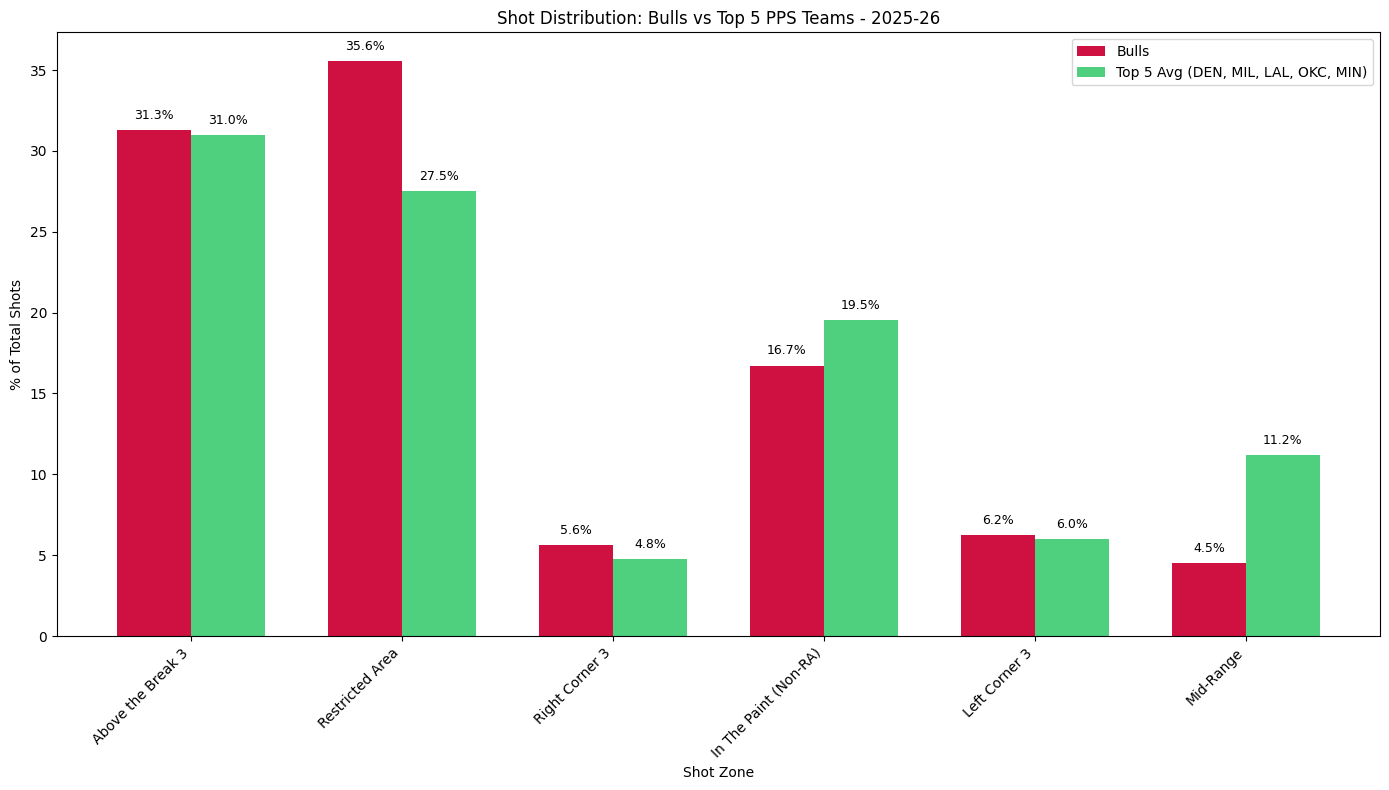


=== Top 5 PPS Teams ===
1. DEN: 1.160 PPS
2. MIL: 1.138 PPS
3. LAL: 1.135 PPS
4. OKC: 1.133 PPS
5. MIN: 1.130 PPS


In [40]:
# Grouped bar chart: Bulls vs Top 5 Teams shot distribution
fig, ax = plt.subplots(figsize=(14, 8))

# Prepare data
x = np.arange(len(zones))
width = 0.35

# Bulls distribution
bulls_pcts = [bulls_distribution.get(z, 0) for z in zones]

# Top 5 average distribution  
top5_pcts = [optimal_distribution.get(z, 0) for z in zones]

bars1 = ax.bar(x - width/2, bulls_pcts, width, label='Bulls', color='#CE1141')
bars2 = ax.bar(x + width/2, top5_pcts, width, label=f'Top 5 Avg ({", ".join(top_5_teams)})', 
               color='#22c55e', alpha=0.8)

# Add value labels
for bar, pct in zip(bars1, bulls_pcts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)
for bar, pct in zip(bars2, top5_pcts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

ax.set_ylabel('% of Total Shots')
ax.set_xlabel('Shot Zone')
ax.set_title(f'Shot Distribution: Bulls vs Top 5 PPS Teams - {CURRENT_SEASON}')
ax.set_xticks(x)
ax.set_xticklabels(zones, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

# Print top 5 team stats
print(f"\n=== Top 5 PPS Teams ===")
for i, team in enumerate(top_5_teams, 1):
    team_pps = league_pps['by_team'][team]['overall']['pps']
    print(f"{i}. {team}: {team_pps:.3f} PPS")

## Step 16: Points Above/Below Expected

Calculate expected points based on league-average efficiency per zone, then compare to Bulls' actual points. This shows net points gained/lost from each zone vs an average team.

In [41]:
# Calculate points above/below expected for each zone
# Formula: (Bulls Zone PPS - League Zone PPS) × Bulls Zone Shots

points_diff_data = []
total_points_above = 0

for zone in zones:
    bulls_zone_pps = bulls_zones.get(zone, {}).get('pps', 0)
    bulls_zone_shots = bulls_zones.get(zone, {}).get('total_shots', 0)
    league_zone_pps = league_zones[zone]['pps']
    
    # Calculate points above/below expected
    pps_diff = bulls_zone_pps - league_zone_pps
    points_diff = pps_diff * bulls_zone_shots
    total_points_above += points_diff
    
    # Expected vs actual points
    expected_points = league_zone_pps * bulls_zone_shots
    actual_points = bulls_zones.get(zone, {}).get('total_points', 0)
    
    points_diff_data.append({
        'Zone': zone,
        'Bulls Shots': bulls_zone_shots,
        'Expected Pts': round(expected_points, 1),
        'Actual Pts': actual_points,
        'Net +/-': round(points_diff, 1),
        'Status': '+' if points_diff > 0 else '-'
    })

points_diff_df = pd.DataFrame(points_diff_data).sort_values('Net +/-', ascending=False)

print("=== Points Above/Below Expected by Zone ===")
print("(Based on league-average PPS per zone)")
print()
print(points_diff_df.to_string(index=False))
print()
print(f"TOTAL Season Impact: {total_points_above:+.1f} points vs league-average team")
print(f"Per Game Impact:     {total_points_above / 42:+.1f} points")

=== Points Above/Below Expected by Zone ===
(Based on league-average PPS per zone)

                 Zone  Bulls Shots  Expected Pts  Actual Pts  Net +/- Status
       Right Corner 3          215         247.2         282     34.8      +
In The Paint (Non-RA)          638         570.4         578      7.7      +
            Mid-Range          173         144.1         136     -8.1      -
        Left Corner 3          238         271.8         261    -10.7      -
    Above the Break 3         1194        1257.3        1233    -23.9      -
      Restricted Area         1356        1810.3        1720    -90.9      -

TOTAL Season Impact: -91.1 points vs league-average team
Per Game Impact:     -2.2 points


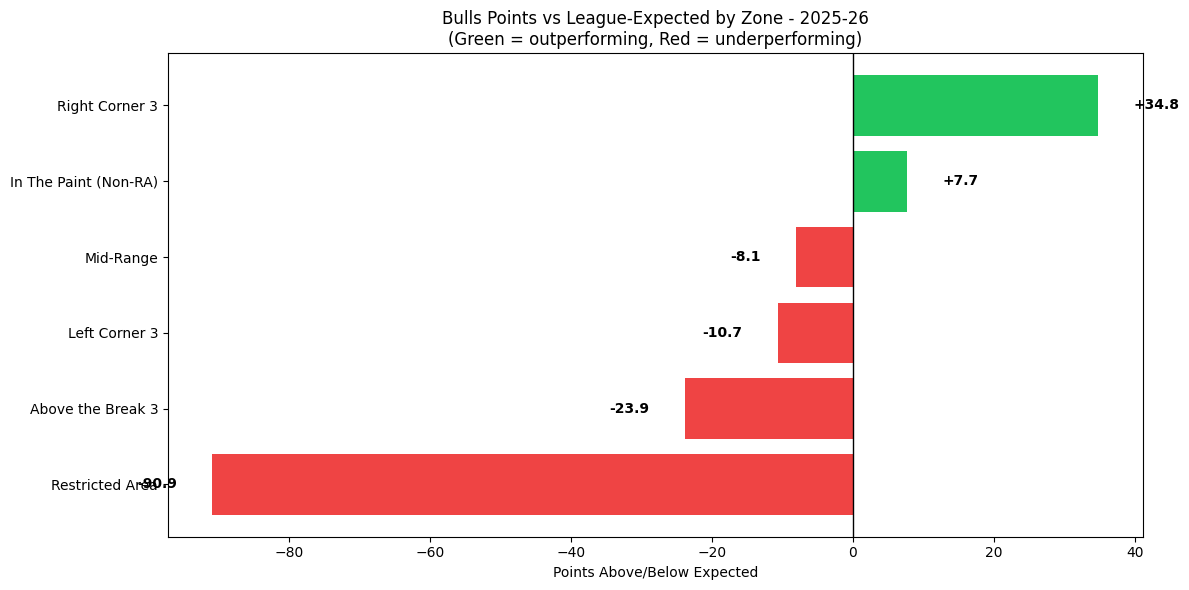

In [42]:
# Bar chart of points above/below expected
fig, ax = plt.subplots(figsize=(12, 6))

# Sort by net impact
plot_df = points_diff_df.sort_values('Net +/-')
colors = ['#22c55e' if val > 0 else '#ef4444' for val in plot_df['Net +/-']]

bars = ax.barh(plot_df['Zone'], plot_df['Net +/-'], color=colors)

# Add zero line
ax.axvline(x=0, color='black', linewidth=1)

# Add value labels
for bar, val in zip(bars, plot_df['Net +/-']):
    x_pos = bar.get_width() + (5 if val >= 0 else -5)
    ha = 'left' if val >= 0 else 'right'
    ax.text(x_pos, bar.get_y() + bar.get_height()/2,
            f'{val:+.1f}', va='center', ha=ha, fontsize=10, fontweight='bold')

ax.set_xlabel('Points Above/Below Expected')
ax.set_title(f'Bulls Points vs League-Expected by Zone - {CURRENT_SEASON}\n(Green = outperforming, Red = underperforming)')

plt.tight_layout()
plt.show()

## Step 17: Zone Dominance Rankings

For each zone, see the top 3 teams and where the Bulls rank. A quick reference for zone-specific strengths across the league.

In [43]:
# Zone Dominance Rankings: Top 3 teams per zone + Bulls rank
zone_leaders_data = []

for zone in zones:
    # Get all teams' PPS for this zone
    zone_pps_list = []
    for team_abbr, team_data in league_pps['by_team'].items():
        pps = team_data['by_zone'].get(zone, {}).get('pps', None)
        if pps is not None:
            zone_pps_list.append((team_abbr, pps))
    
    # Sort by PPS descending
    zone_pps_list.sort(key=lambda x: x[1], reverse=True)
    
    # Get top 3
    top_3 = zone_pps_list[:3]
    
    # Find Bulls rank
    bulls_rank = next((i + 1 for i, (team, _) in enumerate(zone_pps_list) if team == 'CHI'), None)
    bulls_zone_pps = bulls_zones.get(zone, {}).get('pps', 0)
    
    zone_leaders_data.append({
        'Zone': zone,
        '#1': f"{top_3[0][0]} ({top_3[0][1]:.3f})" if len(top_3) > 0 else "-",
        '#2': f"{top_3[1][0]} ({top_3[1][1]:.3f})" if len(top_3) > 1 else "-",
        '#3': f"{top_3[2][0]} ({top_3[2][1]:.3f})" if len(top_3) > 2 else "-",
        'Bulls Rank': f"#{bulls_rank}" if bulls_rank else "-",
        'Bulls PPS': f"{bulls_zone_pps:.3f}"
    })

zone_leaders_df = pd.DataFrame(zone_leaders_data)

print("=== Zone Dominance Rankings ===")
print("Top 3 teams per zone with Bulls' position\n")
print(zone_leaders_df.to_string(index=False))

=== Zone Dominance Rankings ===
Top 3 teams per zone with Bulls' position

                 Zone          #1          #2          #3 Bulls Rank Bulls PPS
    Above the Break 3 DEN (1.183) MIL (1.122) MIN (1.102)        #22     1.033
      Restricted Area LAL (1.489) LAC (1.444) BOS (1.438)        #28     1.268
       Right Corner 3 MEM (1.406) NYK (1.343) CHA (1.332)         #4     1.312
In The Paint (Non-RA) LAL (1.027) BOS (1.009) UTA (0.984)        #11     0.906
        Left Corner 3 MIL (1.390) LAC (1.366) ORL (1.343)        #21     1.097
            Mid-Range DEN (0.944) CLE (0.934) SAS (0.919)        #23     0.786


## Step 18: Efficiency vs Volume Quadrant Analysis

Scatter plot showing each zone's efficiency (PPS) vs volume (% of shots) for all teams. This reveals whether the Bulls are in the optimal quadrants for each zone.

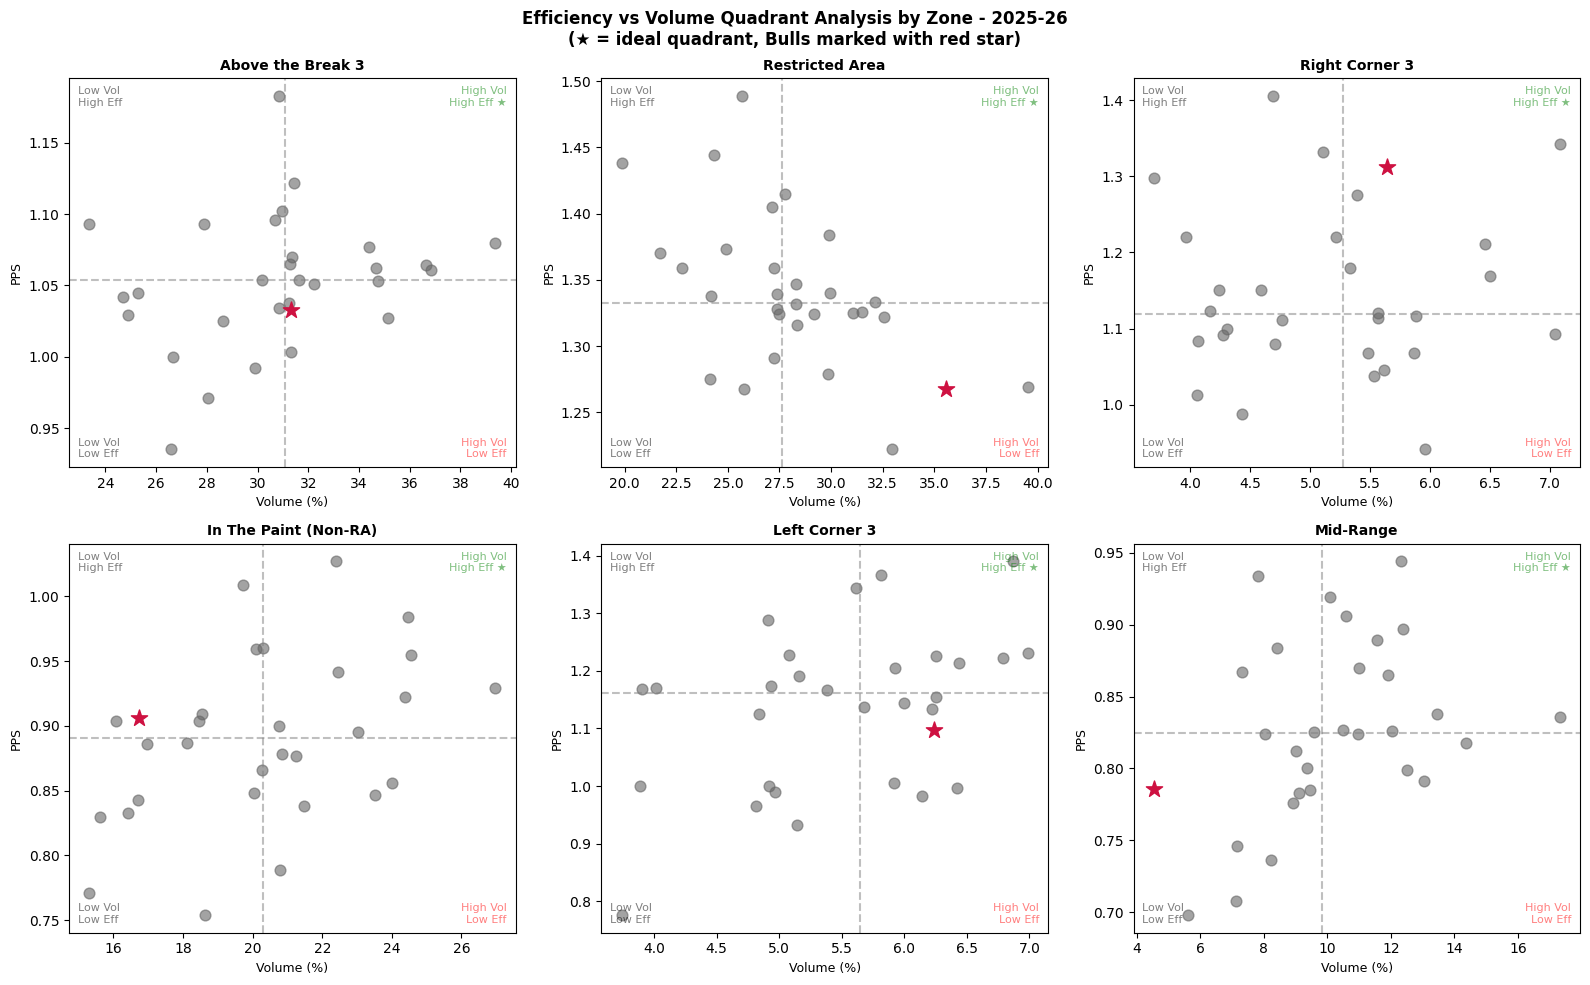

In [44]:
# Quadrant Analysis: Create a grid of scatter plots (one per zone)
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, zone in enumerate(zones):
    ax = axes[idx]
    
    # Collect all teams' data for this zone
    teams_data = []
    for team_abbr, team_data in league_pps['by_team'].items():
        team_total_shots = sum(z.get('total_shots', 0) for z in team_data['by_zone'].values())
        zone_data = team_data['by_zone'].get(zone, {})
        zone_shots = zone_data.get('total_shots', 0)
        zone_pps = zone_data.get('pps', 0)
        
        if zone_shots > 0 and team_total_shots > 0:
            teams_data.append({
                'team': team_abbr,
                'volume': zone_shots / team_total_shots * 100,
                'pps': zone_pps
            })
    
    if not teams_data:
        continue
    
    teams_df = pd.DataFrame(teams_data)
    
    # Calculate medians for quadrant lines
    median_vol = teams_df['volume'].median()
    median_pps = teams_df['pps'].median()
    
    # Plot all teams
    non_bulls = teams_df[teams_df['team'] != 'CHI']
    bulls = teams_df[teams_df['team'] == 'CHI']
    
    ax.scatter(non_bulls['volume'], non_bulls['pps'], c='#666666', alpha=0.6, s=60)
    
    # Highlight Bulls
    if not bulls.empty:
        ax.scatter(bulls['volume'], bulls['pps'], c='#CE1141', s=150, 
                   marker='*', zorder=5, label='Bulls')
    
    # Add quadrant lines
    ax.axhline(y=median_pps, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=median_vol, color='gray', linestyle='--', alpha=0.5)
    
    # Label quadrants
    ax.text(0.02, 0.98, 'Low Vol\nHigh Eff', transform=ax.transAxes, 
            fontsize=8, va='top', ha='left', alpha=0.5)
    ax.text(0.98, 0.98, 'High Vol\nHigh Eff ★', transform=ax.transAxes, 
            fontsize=8, va='top', ha='right', alpha=0.5, color='green')
    ax.text(0.02, 0.02, 'Low Vol\nLow Eff', transform=ax.transAxes, 
            fontsize=8, va='bottom', ha='left', alpha=0.5)
    ax.text(0.98, 0.02, 'High Vol\nLow Eff', transform=ax.transAxes, 
            fontsize=8, va='bottom', ha='right', alpha=0.5, color='red')
    
    ax.set_xlabel('Volume (%)', fontsize=9)
    ax.set_ylabel('PPS', fontsize=9)
    ax.set_title(zone, fontsize=10, fontweight='bold')

plt.suptitle(f'Efficiency vs Volume Quadrant Analysis by Zone - {CURRENT_SEASON}\n(★ = ideal quadrant, Bulls marked with red star)', 
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

---

## Executive Summary

A comprehensive analysis of the Bulls' shooting efficiency compared to the entire NBA.

In [45]:
# Executive Summary
print("=" * 70)
print(f"BULLS PPS ANALYSIS - {CURRENT_SEASON} EXECUTIVE SUMMARY")
print("=" * 70)

# Overall ranking
print(f"\n📊 OVERALL RANKING")
print(f"   Bulls PPS: {bulls_pps:.3f} (#{bulls_rank} of 30 teams)")
print(f"   League Avg: {league_avg_pps:.3f}")
print(f"   Difference: {bulls_pps - league_avg_pps:+.3f}")

# Strengths (zones above league avg)
strengths = comparison_df[comparison_df['Difference'] > 0].sort_values('Difference', ascending=False)
print(f"\n✅ STRENGTHS (Above League Avg in {len(strengths)} zones)")
for _, row in strengths.iterrows():
    print(f"   • {row['Zone']}: {row['Bulls PPS']:.3f} vs {row['League PPS']:.3f} ({row['Difference']:+.3f})")

# Improvement areas (zones below league avg)
weaknesses = comparison_df[comparison_df['Difference'] < 0].sort_values('Difference')
print(f"\n❌ IMPROVEMENT AREAS (Below League Avg in {len(weaknesses)} zones)")
for _, row in weaknesses.iterrows():
    print(f"   • {row['Zone']}: {row['Bulls PPS']:.3f} vs {row['League PPS']:.3f} ({row['Difference']:+.3f})")

# Best zone (highest percentile)
best_zone = percentile_df.iloc[0]
print(f"\n🏆 BEST ZONE: {best_zone['Zone']}")
print(f"   {best_zone['Percentile']:.0f}th percentile (#{int(best_zone['Rank'])} in league)")

# Worst zone (lowest percentile)
worst_zone = percentile_df.iloc[-1]
print(f"\n⚠️  NEEDS WORK: {worst_zone['Zone']}")
print(f"   {worst_zone['Percentile']:.0f}th percentile (#{int(worst_zone['Rank'])} in league)")

# Points impact
print(f"\n💰 SEASON IMPACT vs LEAGUE-AVERAGE TEAM")
print(f"   Total: {total_points_above:+.1f} points")
print(f"   Per Game: {total_points_above / 42:+.1f} points")

# Shot selection analysis
print(f"\n🎯 SHOT SELECTION QUALITY")
print(f"   Actual PPS: {bulls_pps:.3f}")
print(f"   Optimal PPS (Top 5 distribution): {hypothetical_pps:.3f}")
print(f"   Shot selection gap: {hypothetical_pps - bulls_pps:+.3f}")

print("\n" + "=" * 70)

BULLS PPS ANALYSIS - 2025-26 EXECUTIVE SUMMARY

📊 OVERALL RANKING
   Bulls PPS: 1.268 (#23 of 30 teams)
   League Avg: 1.088
   Difference: +0.180

✅ STRENGTHS (Above League Avg in 2 zones)
   • Right Corner 3: 1.312 vs 1.150 (+0.162)
   • In The Paint (Non-RA): 0.906 vs 0.894 (+0.012)

❌ IMPROVEMENT AREAS (Below League Avg in 4 zones)
   • Restricted Area: 1.268 vs 1.335 (-0.067)
   • Mid-Range: 0.786 vs 0.833 (-0.047)
   • Left Corner 3: 1.097 vs 1.142 (-0.045)
   • Above the Break 3: 1.033 vs 1.053 (-0.020)

🏆 BEST ZONE: Right Corner 3
   90th percentile (#4 in league)

⚠️  NEEDS WORK: Restricted Area
   10th percentile (#28 in league)

💰 SEASON IMPACT vs LEAGUE-AVERAGE TEAM
   Total: -91.1 points
   Per Game: -2.2 points

🎯 SHOT SELECTION QUALITY
   Actual PPS: 1.268
   Optimal PPS (Top 5 distribution): 1.062
   Shot selection gap: -0.206



## Key Takeaways

### What We Learned
1. **Overall Efficiency:** The Bulls' PPS ranking among all 30 NBA teams tells us where they stand league-wide
2. **Zone Strengths:** Identified specific zones where the Bulls outperform the league average
3. **Areas for Improvement:** Highlighted zones where efficiency is below league standards
4. **Shot Selection:** Compared Bulls' shot distribution to elite teams to quantify selection quality
5. **Points Impact:** Calculated actual points gained/lost vs league-average performance

### How to Use This Analysis
- **Coaching:** Focus practice on improving efficiency in underperforming zones
- **Game Planning:** Leverage strengths by creating more opportunities in high-efficiency zones
- **Player Development:** Target specific shot types where the team can improve
- **In-Game Decisions:** Prioritize high-value shots based on zone efficiency data

### Visualizations Reference
| Chart | Purpose |
|-------|---------|
| Team Rankings Bar | See Bulls position among all 30 teams |
| Bulls vs League Grouped Bars | Compare efficiency zone-by-zone |
| Team Heatmap | Identify which teams dominate which zones |
| Percentile Radar | Quick view of relative strengths/weaknesses |
| Quadrant Analysis | Understand shot selection vs efficiency tradeoffs |
| Points +/- Bar | See actual impact in points scored |